<a href="https://colab.research.google.com/github/bhuvnk/EVA/blob/master/Assignment6/EVA_Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input
from keras.layers.advanced_activations import ReLU, Softmax
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

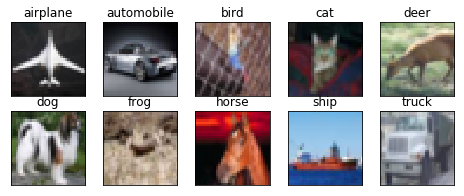

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Fix you


# Solution to assignment 6B

Rewrite using convolutions in the order given below:

1. Normal Convolution
2. Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
3. Depthwise Separable Convolution
4. Grouped Convolution (use 3x3, 5x5 only)
5. Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

In [0]:
## grouped convolution function
def grouped_conv(input, ch_out,  k1, k2, for_name=(2,1), k1_dia=1, k2_dia=1, ):
  
  #convolution type1
  l1 = Conv2D(ch_out, (k1,k1), padding='same', name = 'b{}groupconv{}_p1'.format(*for_name), dilation_rate=(k1_dia, k1_dia), use_bias=False)(input)
  l1 = BatchNormalization()(l1)
  l1 = ReLU()(l1)
  
  #conolution type2
  l2 = Conv2D(ch_out, (k2,k2), padding='same', name = 'b{}groupconv{}_p2'.format(*for_name), dilation_rate=(k2_dia, k2_dia), use_bias=False)(input)
  l2 = BatchNormalization()(l2)
  l2 = ReLU()(l2)
  
  l3 = Concatenate(axis=-1, name = 'b{}groupconv{}_concatenate'.format(*for_name) )([l1,l2])
  
  #lowering down the number
  l4 = Conv2D(ch_out, (1,1), name = 'b{}groupconv{}_ch_down'.format(*for_name), use_bias=False)(l3)
  l4 = BatchNormalization()(l4)
  l4 = ReLU()(l4)
  
  return (l4)
  

In [8]:
input = Input(shape=(32, 32, 3,))

#######################
# Block1
#######################
## 32 || 3
#Normal Convoltion
b1_c1 = Conv2D(16, (3,3), padding='same', name = 'b1c1',  use_bias=False)(input)
b1_c1 = BatchNormalization(name = 'b1c1_normalization')(b1_c1)
b1_c1 = ReLU()(b1_c1)

#Spatially Separable Convolution (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
b1_c2 = Conv2D(16, (3,1), padding='same', name = 'b1c2_seperable_p1', use_bias=False)(b1_c1)
b1_c2 = Conv2D(32, (1,3), padding='same', name = 'b1c2_seperable_p2', use_bias=False)(b1_c2)
b1_c2 = BatchNormalization(name = 'b1c2_normalization',)(b1_c2)
b1_c2 = ReLU()(b1_c2)
b1_c2 = Dropout(0.25)(b1_c2)

# Depthwise Separable Convolution
b1_c3 = SeparableConv2D(64, (3,3), padding='same', name = 'b1c3_depthwise', use_bias=False)(b1_c2)
b1_c3 = BatchNormalization(name = 'b1c3_depthwise_normalization',)(b1_c3)
b1_c3 = ReLU()(b1_c3)
b1_c3 = Dropout(0.25)(b1_c3)

#########
# Trans1
#########
t1_bottle = Conv2D(32, (1,1), padding='same', name = 't1_bottle', use_bias=False)(b1_c3)
t1_bottle = BatchNormalization(name = 't1_bottle_normalization',)(t1_bottle)
t1_bottle = ReLU()(t1_bottle)

t1_mp = MaxPooling2D(pool_size=(2, 2))(t1_bottle)
t1_mp = Dropout(0.25)(t1_mp)
#######################
# Block2
#######################

# Grouped Convolution (use 3x3, 5x5 only)
b2_g1 = grouped_conv(t1_mp, 64, 3, 5, for_name=(2,1))
b2_g1 = Dropout(0.25)(b2_g1)
#Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)
b2_g2 = grouped_conv(b2_g1, 128, 3, 3, for_name=(2,2), k2_dia=2)
b2_g2 = Dropout(0.25)(b2_g2)
#########
# Trans2
#########
t2_bottle = Conv2D(64, (1,1), padding='same', name = 't2_bottle', use_bias=False)(b2_g2)
t2_bottle = BatchNormalization(name = 't2_bottle_normalization')(t2_bottle)
t2_bottle = ReLU()(t2_bottle)

t2_mp = MaxPooling2D(pool_size=(2, 2))(t2_bottle)
t2_mp = Dropout(0.25)(t2_mp)
#######################
# Block3
#######################
# Grouped Convolution (use 3x3, 5x5 only)
b3_g1 = grouped_conv(t2_mp, 128, 3, 5, for_name=(3,1))
b3_g1 = Dropout(0.25)(b3_g1)

#Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)
b3_g2 = grouped_conv(b3_g1, 256, 3, 3, for_name=(3,2), k2_dia=2)
b3_g2 = Dropout(0.25)(b3_g2)

############

reduce_ch = Conv2D(10, (1,1), name = 'to_numclass', use_bias=False)(b3_g2)
avg_pool = GlobalAveragePooling2D()(reduce_ch)
output = Softmax()(avg_pool)


model = Model(inputs=[input], outputs=[output])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
b1c1 (Conv2D)                   (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
b1c1_normalization (BatchNormal (None, 32, 32, 16)   64          b1c1[0][0]                       
__________________________________________________________________________________________________
re_lu_1 (ReLU)       

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  


Epoch 1/50
390/390 [==============================] - 72s 185ms/step - loss: 1.4461 - acc: 0.4696 - val_loss: 1.8979 - val_acc: 0.4126
Epoch 2/50
390/390 [==============================] - 66s 169ms/step - loss: 1.0375 - acc: 0.6300 - val_loss: 1.4646 - val_acc: 0.5237
Epoch 3/50
390/390 [==============================] - 65s 168ms/step - loss: 0.8715 - acc: 0.6911 - val_loss: 1.0660 - val_acc: 0.6320
Epoch 4/50
390/390 [==============================] - 65s 167ms/step - loss: 0.7625 - acc: 0.7315 - val_loss: 0.9164 - val_acc: 0.6806
Epoch 5/50
390/390 [==============================] - 65s 168ms/step - loss: 0.6839 - acc: 0.7608 - val_loss: 0.9289 - val_acc: 0.6776
Epoch 6/50
390/390 [==============================] - 65s 167ms/step - loss: 0.6269 - acc: 0.7792 - val_loss: 0.9648 - val_acc: 0.6801
Epoch 7/50
390/390 [==============================] - 65s 167ms/step - loss: 0.5795 - acc: 0.7975 - val_loss: 0.8949 - val_acc: 0.7030
Epoch 8/50
390/390 [==============================] - 6

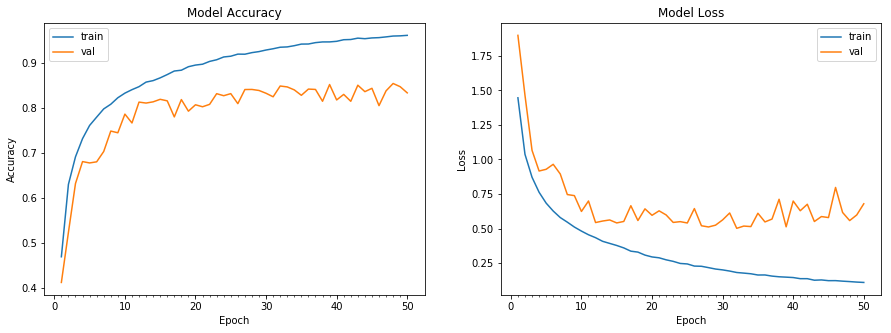

Accuracy on test data is: 83.30


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))